# Melody GAN
Tin's First GAN attempt

You can download the dataset from my [google drive](https://drive.google.com/file/d/163ra5xe1WlVFRa6D3P-Ti1dFh2cp0Veg/view?usp=sharing). 

In [ ]:
#Skip this if you have already installed the required packages
#This jupyter is developed under python3.7.5, numpy 1.17.4, music21 5.7.1, tensorflow 2.0, opencv-python 4.1.1.26 
!pip3 install numpy music21 tensorflow opencv-python sklearn matplotlib

In [2]:
#Skip this if you have already unzipped the dataset
!unzip midi_data.zip

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
from music21 import converter, instrument, note, chord, stream, interval, pitch, midi
import sys, os
from IPython.display import Image
from IPython.core.display import HTML
import tensorflow as tf
from tensorflow import keras
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [3]:
#Set the logging level (If you change 'WARNING' to something else, the progress bar interface might be broken.)
tf.get_logger().setLevel('WARNING')

#For easy reset of notebook state.
tf.keras.backend.clear_session()

#Checking available CPU/GPU.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15233610405324614187
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9884357277349522865
physical_device_desc: "device: XLA_CPU device"
]


#### Note: Since keyword 'note' and 'stream' is used by music21 API, we will use variable 'n' to refer a note, and 's' to refer a stream below.

First, let's define functions to play some pokemon music.

In [4]:
def play_midiFile(midFile):
    """
    Play the target midi file.
    """
    mid = converter.parse(midFile)
    mid.show('midi')
    
def play_stream(stream):
    """
    Play the target midi stream.
    """
    stream.write('midi', fp='temp.mid')
    play_midiFile('temp.mid')


In [5]:
play_midiFile('./Random_melody/pokemon-rgby-trainer-battle.mid')

## Music21 Intro
We use music21 midi API in this experiment. Once the file is loaded into music21, it produces a stream which consists of midi notes.

Each note has a pitch (C,D,E,F,G,A,B, with accidental sharps,flats...) along with the corresponding octave in keyboard.

In [6]:
mid = converter.parse('./Random_melody/pokemon-rgby-trainer-battle.mid')
s = instrument.partitionByInstrument(mid)[0]
first_note = s.notes[0]
print(first_note.pitch)   #The first note is A at 5th octave. You can verify it at the midi player above.
print(first_note.pitch.name)   #return the key name of the first note
print(first_note.pitch.octave)   #return the key octave of the first note

A5
A
5


In [7]:
my_note = note.Note('B#', quarterLength=1)   #creating a note
print(my_note.pitch.name)

B#


Midi's octave ranges from 0 to 10. However, in reality, octaves outside range 3 to 6 are rarely used in melody, so we'll force all note's octave to be in this range(3 to 6).

Each note also has a duration, representing how long the note last in the track.<br>
0.25 = 16th note<br>
0.5 = 8th note<br>
1 = quarter note<br>
2 = half note<br>
4 = whole note<br>
![](http://hub.rockyview.ab.ca/pluginfile.php/5627/mod_book/chapter/3630/notes%20and%20rests.PNG)

In [8]:
print(first_note.duration)   #note has a Duration object
print(first_note.duration.quarterLength)   #return value of duration
print(first_note.duration.type)   #return string representation of duration
set([note.duration.type for note in s.notesAndRests])   #see all possible duration of this song

<music21.duration.Duration 0.25>
0.25
16th


{'16th', 'complex', 'eighth', 'half', 'quarter', 'whole'}

Complex duration means a note need multiple tied noteheads to represent. Complex duration's value can vary drastically, so our model we treat them as quarter note.<br>
Also, for the same reason, we treat all notes which their duration exceed the 4 as whole note, and all notes which their duration shorter than 0.25 as 16th note.

## Midi Preprocessing

Here we define something we want to do with raw midi files before converting them into values:<br>
1. Transform all midi into C major/minor to reduce unnecessary variance in training.
2. Transform notes if their duration is greater than whole note or less than 16th note as stated above.
3. Transform notes it their octave is not within 3 and 6 as stated above.

In [9]:
def transform_to_C(inputStream):
    i = interval.Interval(inputStream.analyze('key').tonic, pitch.Pitch('C'))
    return inputStream.transpose(i)

In [10]:
def transform_note(inputStream):
    """
    Remove rest notes, and enforce the duration limits.
    """
    s = stream.Stream()
    for n in inputStream.flat.notes:
        if isinstance(n, chord.Chord):
            n = n.notes[0]
        note_duration = n.duration.type
        if note_duration == 'complex':
            note_duration = 'quarter'
        elif n.duration.quarterLength < 0.25:
            note_duration = '16th'
        elif n.duration.quarterLength > 4:
            note_duration = 'whole'
        
        n.pitch.octave = min(max(n.pitch.octave, 3), 6)
        note_pitch = n.pitch.nameWithOctave
        s.append(note.Note(pitchName=note_pitch, type=note_duration))
    return s

s = transform_note(transform_to_C(s))
play_stream(s)

## Video clips Preprocessing

We also define function to preprocess video clips by resizing and ormalizing pixels.

In [11]:
expected_clip_shape = (9, 64, 64, 3)   #any image differ to this shape will be dropped
def transform_images(clips):
    """
    Preprocess video clips (collection of images).
    """
    clip_sample = []
    for i in range(clips.shape[0]):
        images = []
        for j in range(clips[i].shape[0]):
            resized_img = cv2.resize(clips[i][j], dsize=(expected_clip_shape[1], expected_clip_shape[2]))
            images.append(resized_img)
        clip_sample.append(images)
    return np.array(clip_sample) / 255.0

## Converting between midi stream and note representation
We now define function to convert all notes into an array of tuple (id, duration), and its reverse function. These functions will be used to convert the data to feed our model, and convert the model's output to proper midi file.

#### Pitch:
Since we assume all note has octave between 3 to 6. The lowest pitch is 'C3'=48, the highest pitch is 'B6'=95. However, if we simply put pitches with range(48, 95) into our data, then our data will have bias. To normalize our data, we will map the range(48, 95) to range(-1,1).<br><br>
The mapping formula is:<br>
$$Pitch(x) = \frac{(1-(-1))}{(95-48)} * {(x - (48 + \frac{95 - 48}{2}))}$$
$$\rightarrow f(x) = \frac{2x - 143}{47}$$

Its reverse function will map range(-1,1) back to range(48,95).<br>
The reverse formula is:<br>
$$Pitch^{-1}(x) = \frac{47x + 143}{2}$$

#### Duration:
Desipte durations are represented in real numbers like pitches, they actually correspond to 5 classes(16th=0.25, 8th=0.5, quarter=1, half=2, whole=4). To normalize our data, we will map them into range(-1, 1) with the following discrete mapping rules:<br>

$$
\begin{equation}
  Duration(x) =
    \begin{cases}
      -1. & \text{if x = 0.25 (16th)}\\
      -0.5 & \text{if x = 0.5 (8th)}\\
      0 & \text{if x = 1 (quarter)}\\
      0.5 & \text{if x = 2 (half)}\\
      1 & \text{if x = 4 (whole)}\\
    \end{cases}       
\end{equation}
$$

Its reverse function will look at the value and chose its closest duration class. For example, if value is -0.1, then it will be first changed to 0, then mapped back to 1(quarter).

In [12]:
PITCH_RANGE = (48, 95)  #in octave 3 to 6, the lowest pitch is 'C3'=48, the highest pitch is 'B6'=95.
duration_map = {0.25: -1., 0.5: -0.5, 1.: 0., 2.:0.5, 4.:1}
def stream_to_noteArr(s):
    """
    Map midi stream to numpy representation.
    """
    result = []
    for n in s:
        mapped_pitch = (2 * n.pitch.midi-143)/(47)
        try:
            mapped_duration = duration_map[n.duration.quarterLength]
        except KeyError:
            mapped_duration = 1.
        result.append([mapped_pitch, mapped_duration])
    return np.array(result)

In [13]:
inverse_duration_map = {-1.: 0.25, -0.5: 0.5, 0.: 1., 0.5: 2, 1.: 4}
inverse_duration_map_keys = [-1., -0.5, 0., 0.5, 1.]
def noteArr_to_stream(arr):
    """
    Reverse function of stream_to_noteArr.
    """
    
    s = stream.Stream()
    for pitch, duration in arr:
        mapped_pitch = int((47 * pitch + 143) / 2)
        
        closest_duration_index = (np.abs(inverse_duration_map_keys - duration)).argmin()
        closest_duration = inverse_duration_map_keys[closest_duration_index]
        mapped_duration = inverse_duration_map[closest_duration]
        
        n = note.Note()
        n.pitch.midi = mapped_pitch
        n.duration.quarterLength = mapped_duration
        s.append(n)
    return s

## Loading Data
In this experiment, we have prepared a simple dataset from Final Fantasy, Super Mario Bros, and some other random games.
The dataset consists of video clips (9 frames of 200x200 images) and its corresponding midi file.

In our training data, each clip will associated with several note sequences picked from the corresponding midi file, so that each clip is paired with music that has correct "emotion".

In [14]:
#Model Hyperparameters
NOTES_PER_SEQ = 20   #how many notes in a sequence

#Dataset Hyperparameters
all_dir = ['./Final_Fantasy', './Random_melody', './Super_Mario_Bros']   #what data needs to be included in training. Feel free to add more folder if you have more data.
all_dir = ['./Final_fantasy'] #For debug only, I use one folder because they take too many memory of my poor macbook air
SEQ_PER_CLIPS = 4    #how many training sequence for a video clip
NOTE_STEP = 1    #step size of the slide for note sequence

In [15]:
def load_data(all_dir):
    img_data = []
    midi_data = []
    for folder in all_dir:
        for file in os.listdir(folder):
            if file.endswith(".mid"):
                name = file.split('.')[0]
                
                #Load midi file
                try:
                    mid = converter.parse(folder+'/'+file)
                    s = instrument.partitionByInstrument(mid)[0]   #extract melody
                except:
                    print(f"something is wrong when opening {folder+'/'+file}")
                    continue
                s = transform_note(transform_to_C(s))   #preprocessing midi
                s = stream_to_noteArr(s)   #to value representation 
                
                #Load corresponding npy file
                try:
                    clips = np.load(folder+'/'+name+'.npy')
                except:
                    print(f"something is wrong when opening {folder+'/'+name+'.npy'}")
                    continue
                    
                clips = transform_images(clips)   
                
                for clip in clips:
                    for i in range(0, len(s) - NOTES_PER_SEQ, NOTE_STEP):
                        if clip.shape == expected_clip_shape:
                            img_data.append(clip)
                            midi_data.append(s[i:i+NOTES_PER_SEQ])
                            
    return np.array(img_data), np.array(midi_data)

In [16]:
img_data, midi_data = load_data(all_dir)
img_data.shape

(14618, 9, 64, 64, 3)

## Construct model

In [17]:
class Encoder(keras.Model):
    def __init__(self, output_dim):
        """
        output_dim: the dimension of the encoded vector
        """
        super(Encoder, self).__init__()        
        self.conv1 = tf.keras.layers.Conv3D(8, [3, 4, 4], padding='same', name='en_conv1')
        self.pool1 = keras.layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='en_pool1')
        self.conv2 = tf.keras.layers.Conv3D(16, [3, 5, 5], padding='same', name='en_conv2')
        self.bn2 = keras.layers.BatchNormalization(name='en_bn2')
        self.conv3 = tf.keras.layers.Conv3D(16, [3, 3, 3], padding='same', name='en_conv3')
        self.bn3 = keras.layers.BatchNormalization(name='en_bn3')
        self.flatten4 = keras.layers.Flatten(name='en_flatten')
        self.dense4 = keras.layers.Dense(output_dim, name='en_dense4')
        
    def call(self, inputs):
        x = tf.nn.leaky_relu(self.pool1(self.conv1(inputs)))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x)))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x)))
        x = self.dense4(self.flatten4(x))
        return x
        
        
class Generator(keras.Model):
    def __init__(self, output_dim):
        """
        input_dim: the dimension of the encoded vector
        outpu_dim: the amount of notes(in pair of pitch and duration) to be generated
        """
        super(Generator, self).__init__()
        self.dense1 = keras.layers.Dense(output_dim*2, name='gen_dense1')
        self.dense2 = keras.layers.Dense(output_dim*4, name='gen_dense2')
        self.bn2 = keras.layers.BatchNormalization(name='en_bn2')
        self.dense3 = keras.layers.Dense(output_dim*2, name='gen_dense3')
        self.reshape = keras.layers.Reshape((output_dim, 2))
        
    def call(self, encode_input):
        x = tf.nn.leaky_relu(self.dense1(encode_input))
        x = tf.nn.leaky_relu(self.bn2(self.dense2(x)))
        x = self.reshape(self.dense3(x))
        return x
        
    
class Discriminator(keras.Model):

    def __init__(self, dim_encoded_img, dim_encoded_midi):
        """
        dim_lstm_output: the dimension of lstm layer of midi data.
        """
        super(Discriminator, self).__init__()
        self.lstm1 = tf.keras.layers.LSTM(dim_encoded_midi, name='dis_lstm1')
        
        total = dim_encoded_img + dim_encoded_midi
        self.dense3 = keras.layers.Dense(total, name='dis_dense3')
        self.bn3 = keras.layers.BatchNormalization(name='en_bn3')
        
        self.dense4 = keras.layers.Dense(total*2, name='dis_dense4')
        self.bn4 = keras.layers.BatchNormalization(name='en_bn4')
        
        self.dense5 = keras.layers.Dense(1, name='dis_dense5')
        
    def call(self, inputs):
        encoded_img, midi_input = inputs
        encoded_midi = self.lstm1(midi_input)
        concat = tf.keras.layers.concatenate([encoded_img, encoded_midi])
        
        x = tf.nn.leaky_relu(self.bn3(self.dense3(concat)))
        x = tf.nn.leaky_relu(self.bn4(self.dense4(x)))
        x = keras.activations.sigmoid(self.dense5(x))
        return x

In [18]:
class Melody_GAN:
    def __init__(self):
        #hyperparameters
        self.notes_per_seq = NOTES_PER_SEQ
        self.encoder_output_dim = 16
        self.num_epoch_Encoder = 60
        self.num_epoch_GAN = 40
        self.batch_size = 10
        self.learning_rate = 0.0001
        self.num_fake_music = 30  #number of fake music generated in each epoch. 
        self.save_per_epoch = 100 #number of epoches to save the model once
        self.record_per_epoch = 20 #number of epoches to save the loss for plotting the result
        
        #main component models
        self.encoder = Encoder(self.encoder_output_dim)
        self.generator = Generator(self.notes_per_seq)
        self.discriminator = Discriminator(self.encoder_output_dim, self.encoder_output_dim)
        
        #optimizers
        self.encoded_optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.generator_optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.discriminator_optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        
        #Run predict() once to let the model knows the input shape. The model cannot be saved to file without this step.
        a = self.encoder.predict(np.zeros((1, expected_clip_shape[0], expected_clip_shape[1], expected_clip_shape[2], expected_clip_shape[3])))   
        b = self.generator.predict(np.zeros((1, self.encoder_output_dim)))
        c = self.discriminator.predict([a,b])
    
        #for saving checkpoint
        self.checkpoint = tf.train.Checkpoint(encoder=self.encoder,
                                              generator=self.generator,
                                              discriminator=self.discriminator,
                                              encoded_optimizer=self.encoded_optimizer,
                                              generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer)
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, './tmp/model', max_to_keep=5)
        
        #for plotting
        self.train_record_Encoder = []
        self.train_record_GAN_gen = []
        self.train_record_GAN_dis = []

    def _loss(self, logits, labels):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(name='cross_entropy')
        return cross_entropy(labels, logits)
    
    def train(self, img_data, midi_data):
        """
        Train the computation graph. There are two stages:
        The first stage trains the encoder and discriminator until it is good enough.
        The second stage trains the generator and discriminator like normal GAN.
        """
        self.img_data, self.midi_data = shuffle(img_data, midi_data)
        print('Complete shuffling data.')
        self.img_iter = iter(tf.data.Dataset.from_tensor_slices(self.img_data).batch(self.batch_size).repeat())
        self.midi_iter = iter(tf.data.Dataset.from_tensor_slices(self.midi_data).batch(self.batch_size).repeat())
        
        self._train_Encoder(img_data, midi_data)
        self._train_GAN(img_data, midi_data)
    
    def _train_Encoder(self, img_iter, midi_iter):
        """
        Train the encoder and discriminator.
        """
        for epoch in range(self.num_epoch_Encoder):
            #Create Progressbar
            progbar = keras.utils.Progbar(self.num_epoch_Encoder)
            
            #Train Discriminator and Encoder
            with tf.GradientTape(persistent=True) as tape:
                img_batch, midi_batch = next(self.img_iter), next(self.midi_iter)
                fake_music = self.generator(np.random.normal(0, 1, (self.batch_size, self.encoder_output_dim)))   #generate from random number is enough, since we are not concern about training generator.

                encoded_img = self.encoder(img_batch)
                real_logits = self.discriminator([encoded_img, midi_batch])
                fake_logits = self.discriminator([encoded_img, fake_music])

                real_loss = self._loss(real_logits, np.ones(self.batch_size))
                fake_loss = self._loss(fake_logits, np.zeros(self.batch_size))
                loss = real_loss + fake_loss
                
            d_grads = tape.gradient(loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
            
            en_grads = tape.gradient(loss, self.encoder.trainable_variables)
            self.encoded_optimizer.apply_gradients(zip(en_grads, self.encoder.trainable_variables))         
            del tape
            
            #Show Progress
            progbar.update(epoch, values=[('loss', loss)])
            if epoch % self.record_per_epoch == 0:   #save traing loss every 20 epoches
                self.train_record_Encoder.append(loss)
            if epoch % self.save_per_epoch == 0:  #save model every 100 epoches
                self.save_model()
                
        print('\ntrain_Encoder complete!')
        
    def _train_GAN(self, img_iter, midi_iter):
        """
        Train the generator and discriminator.
        """
        dis_loss, gen_loss = 0, 0
        #Create Progressbar
        progbar = keras.utils.Progbar(self.num_epoch_GAN)  
        
        for epoch in range(self.num_epoch_GAN):
            #Discriminator's turn
            with tf.GradientTape() as tape:
                img_batch, midi_batch = next(self.img_iter), next(self.midi_iter)
                fake_music = self.generator(np.random.normal(0, 1, (self.batch_size, self.encoder_output_dim)))   #generate from random picture
                
                encoded_img = self.encoder(img_batch)
                real_logits = self.discriminator([encoded_img, midi_batch])
                fake_logits = self.discriminator([encoded_img, fake_music])
                
                real_loss = self._loss(real_logits, np.ones(self.batch_size))
                fake_loss = self._loss(fake_logits, np.zeros(self.batch_size))
                dis_loss = real_loss + fake_loss
                
            d_grads = tape.gradient(dis_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))      
            del tape
            
            #Generator's turn
            with tf.GradientTape() as tape:
                rand_img = img_data[np.random.choice(self.img_data.shape[0], self.batch_size, replace=False)]
                noisy_rand_img = rand_img + np.random.normal(0, 0.1, rand_img.shape)
                
                encoded_img = self.encoder(noisy_rand_img)
                fake_music = self.generator(encoded_img)
                fake_logits = self.discriminator([encoded_img, fake_music])
                
                gen_loss = self._loss(fake_logits, np.zeros(self.batch_size))
                
            g_grads = tape.gradient(gen_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
            del tape
            
            #Show Progress
            progbar.update(epoch, values=[('dis_loss', dis_loss), ('gen_loss', gen_loss)])
            if epoch % self.record_per_epoch == 0:
                self.train_record_GAN_gen.append(gen_loss)
                self.train_record_GAN_dis.append(dis_loss)
            if epoch % self.save_per_epoch == 0:
                self.save_model()
                
        print('\ntrain_GAN completed!')
        
    def generate_midi(self, img_data):
        """
        Given a clip, generate midi music
        """
        encoded_img = self.encoder.call(img_data)
        return self.generator.call(encoded_img)
    
    def save_model(self, disable_log=True):
        if not disable_log:
            print('Saving models...')      
        self.checkpoint_manager.save()      
        if not disable_log:
            print('Save completed.')
            
    def load_model(self, disable_log=True):
        if not disable_log:
            print('Loading models...')
        self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint) 
        if not disable_log:
            print('Load completed.')
        
    def plot_training(self):
        plt.plot(range(0, self.num_epoch_Encoder, self.record_per_epoch), self.train_record_Encoder)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.suptitle('Training loss (First Stage)')
        plt.show()
                     
        gen_line, = plt.plot(range(0, self.num_epoch_GAN, self.record_per_epoch),
                 self.train_record_GAN_gen,
                 color='red')
                    
        dis_line, = plt.plot(range(0, self.num_epoch_GAN, self.record_per_epoch),
                  self.train_record_GAN_dis,
                  color='blue')
        plt.suptitle('Training loss (Second Stage)')
        plt.xlabel('epoch')
        plt.ylabel('loss')          
        plt.legend((dis_line, gen_line), ('discriminator', 'generator'))
        plt.show()
            

# Training the model

In [19]:
gan = Melody_GAN()
gan.train(img_data, midi_data)   #Try 'gan.train(img_data[:20], midi_data[:20])' if you think it's too slow.

Complete shuffling data.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer const

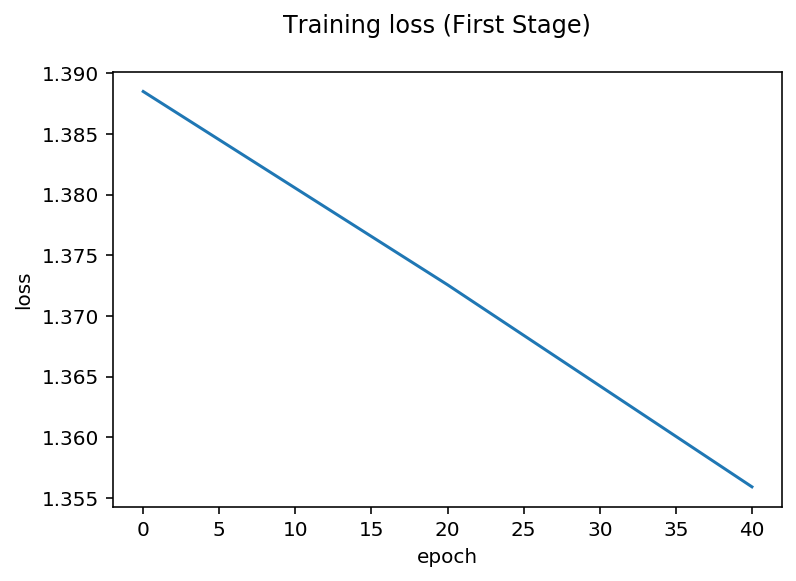

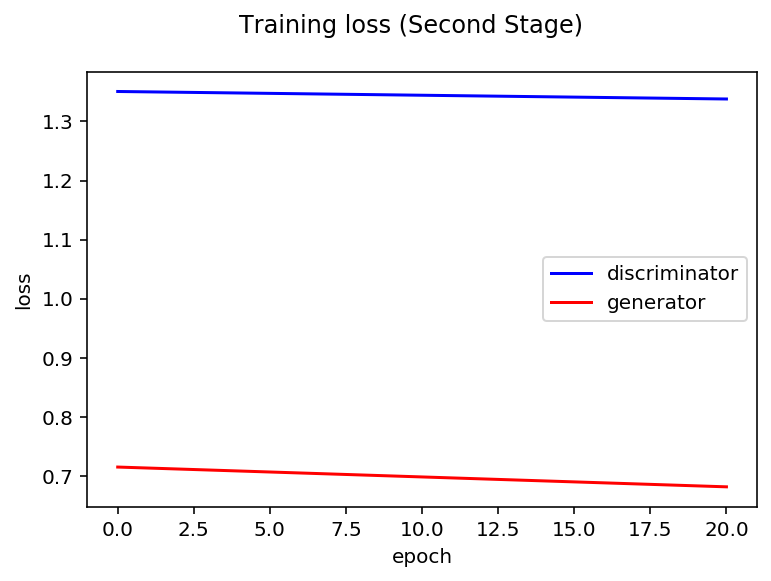

In [20]:
gan.plot_training()

# Let's generate some music!

In [33]:
#Randomly pick a video clip from img_data and generate music from it
index = np.random.randint(img_data.shape[0])
generated_music = gan.generate_midi([img_data[index]])

Some Frames from the video clip:


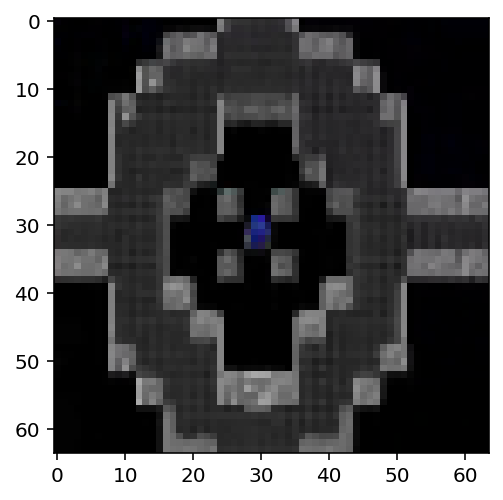

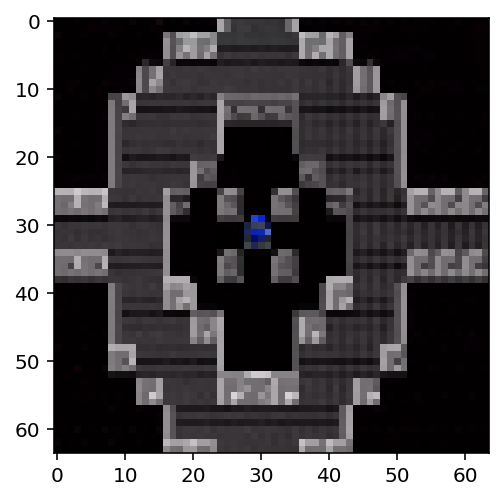

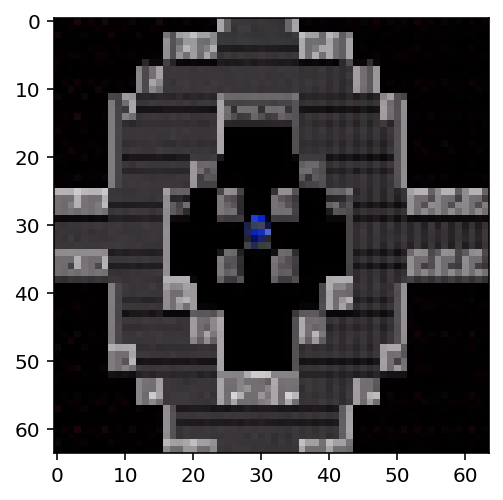

Real game music:


Generated game music:


In [34]:
print('Some Frames from the video clip:')
plt.imshow(img_data[index][0])
plt.show()
plt.imshow(img_data[index][3])
plt.show()
plt.imshow(img_data[index][6])
plt.show()
print('Real game music:')
real_music = noteArr_to_stream(midi_data[index])
play_stream(real_music)
print('Generated game music:')
generated_music = noteArr_to_stream(generated_music[0])
play_stream(generated_music)